# 知识增益与上下文相关性

## 三个不同上下文设定的分布
- 折线图
- 横轴是知识增益
- 纵轴是准确率增益
- 数据点半径是样本数量

In [1]:
%load_ext autoreload
%autoreload 2

import json
import warnings
import os
import pickle
from tqdm import tqdm
import torch
from collections import defaultdict, Counter
import argparse
from core.models.entailment import EntailmentDeberta
from core.data.data_utils import load_ds_from_json
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from core.computation.uncertainty_measure import cluster_assignment_entropy

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
rng = np.random.default_rng(42)


def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            it = {}
            it['text'] = r['text']
            it['slt_emb'] = r['hidden_states']['sec_last_token_embedding']
            it['tbg_emb'] = r['hidden_states']['last_tok_bef_gen_embedding']
            responses.append(it)
    return responses

def load_greedy_response(generation_file_path):
    responses = load_responses(generation_file_path)
    assert len(responses) <= 1, f"More than one response found in {generation_file_path}."
    return responses[0] if len(responses) == 1 else None

def load_sample_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            responses.append(r['text'])
    return responses

def load_qwen_accuracy(eval_file_path):
    accuracy = []
    if os.path.exists(eval_file_path):
        res = load_pickle_file(eval_file_path)
        accuracy = res.get('qwen_scores', [])
    return accuracy[0] if len(accuracy) == 1 else None

def load_cluster_ids(clustered_file_path):
    cluster_ids = []
    if os.path.exists(clustered_file_path):
        res = load_pickle_file(clustered_file_path)
        cluster_ids = res.get('cluster_ids', [])
    return cluster_ids

# 计算语义熵
def compute_entropy(cluster_ids):
    if len(cluster_ids) == 0:
        return -1
    return cluster_assignment_entropy(cluster_ids)

# 数据
`qwen-bioasq.pkl`

```
{
	"meta": {
		"model": "qwen",
		"dataset": "bioasq"
	},
	"data": [{
		"example": {
			"id": "id1",
			"question": "q1",
			"context": "c1",
			"answers": ["a1"]
		},
		"golden": {
			"greedy_response": "gready_text",
			"tbg_emb": Tensor(),
			"slt_emb": Tensor(),
			"sample_responses": ["response1","response2"],
			"cluster_ids": [0,1],
			"entropy": 1.5,
			"accuracy_qwen": 1.0,
			"accuracy_gpt": 1.0,
		},
		"irrelevant": {},
		"without": {},
	}]
}

```

In [2]:
# 检查数据是否完整
def check_item(item):
    for context_type in ["golden", "irrelevant", "without"]:
        if context_type not in item:
            return False
        context = item[context_type]
        if context.get("tbg_emb", None) is None:
            return False
        if context.get("slt_emb", None) is None:
            return False
        if context.get("greedy_response", None) is None:
            return False
        if context.get("sample_responses", None) is None:
            return False
        if context.get("cluster_ids", None) is None:
            return False
        if context.get("entropy", None) is None:
            return False
        if context.get("accuracy_qwen", None) is None:
            return False
        if len(context["sample_responses"]) != len(context["cluster_ids"]):
            return False
    
    return True

all_data = load_pickle_file("output/data/qwen-bioasq.pkl")
data = []
for item in all_data["data"]:
    if check_item(item):
        data.append(item)
        # diff_entropy.append(item["golden"]["entropy"] - item["irrelevant"]["entropy"])
        # diff_acc.append(item["golden"]["accuracy_qwen"] - item["irrelevant"]["accuracy_qwen"])
print(f"valid data: {len(data)}")

valid data: 1997


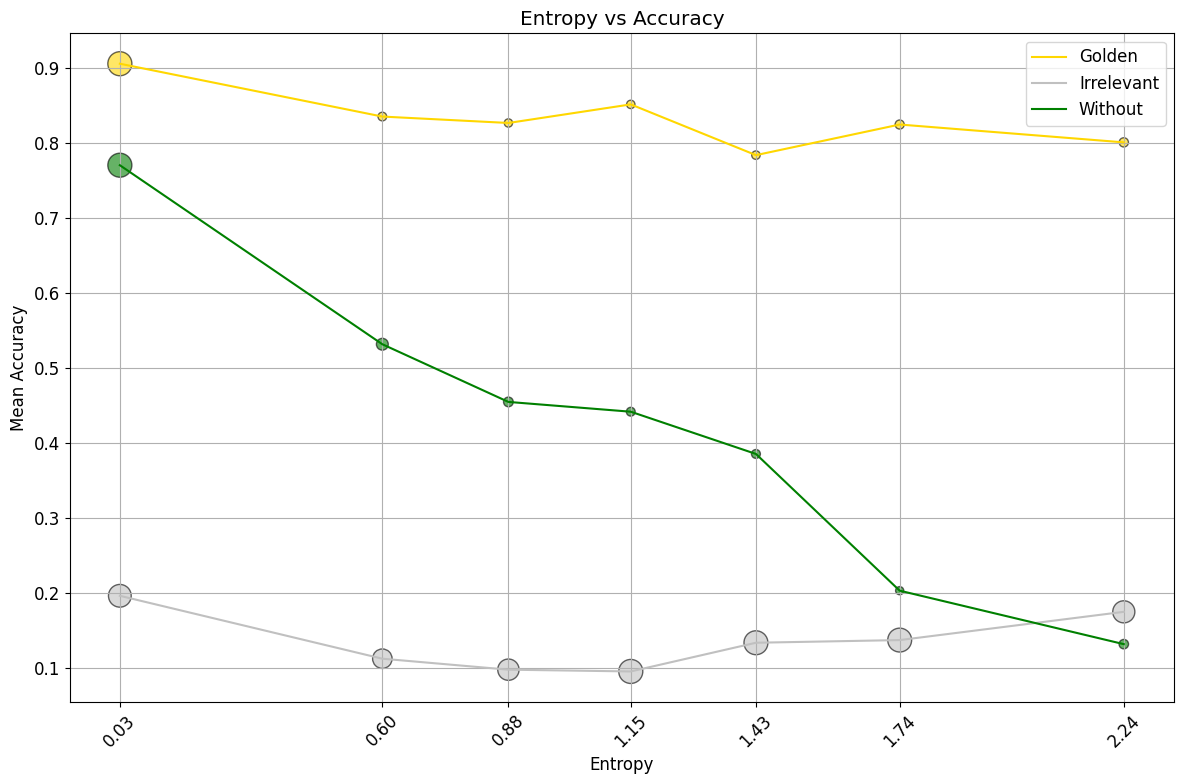

In [3]:
'''
画折线图
查看三个不同上下文设定的分布（golden黄色, without灰色, irrelevant黑色）
- 横轴是分箱的entropy
- 纵轴是平均accuracy
- 数据点半径是样本数量
'''

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 假设您的数据存储在名为data的变量中
# data = [...]  # 这里应该是您的2000条数据

# 示例数据结构（请用您的实际数据替换）
# data = [
#     {
#         "golden": {"entropy": 1.5, "accuracy_qwen": 1.0},
#         "irrelevant": {"entropy": 2.0, "accuracy_qwen": 0.8},
#         "without": {"entropy": 1.2, "accuracy_qwen": 0.9},
#     },
#     # ... 共2000条
# ]

# 将数据转换为DataFrame
def preprocess_data(data):
    records = []
    for entry in data:
        for context in ['golden', 'irrelevant', 'without']:
            context_data = entry.get(context, {})
            records.append({
                'context': context,
                'entropy': context_data.get('entropy', np.nan),
                'accuracy_qwen': context_data.get('accuracy_qwen', np.nan)
            })
    df = pd.DataFrame(records)
    # 去除缺失值
    df = df.dropna(subset=['entropy', 'accuracy_qwen'])
    return df

# 假设data已经被定义
df = preprocess_data(data)

# 分箱
num_bins = 10
df['entropy_bin'] = pd.qcut(df['entropy'], q=num_bins, duplicates='drop')

# 为每个箱计算中心值用于绘图
bin_centers = df.groupby('entropy_bin')['entropy'].mean()

# 计算每个上下文和每个箱的平均准确率和样本数量
grouped = df.groupby(['context', 'entropy_bin']).agg(
    average_accuracy=('accuracy_qwen', 'mean'),
    sample_count=('accuracy_qwen', 'count')
).reset_index()

# 创建一个透视表，以便每个上下文都有独立的列
pivot_accuracy = grouped.pivot(index='entropy_bin', columns='context', values='average_accuracy')
pivot_count = grouped.pivot(index='entropy_bin', columns='context', values='sample_count')

# 定义颜色映射
color_map = {
    'golden': 'gold',
    'irrelevant': 'silver',
    'without': 'green'
}

# 绘图
plt.figure(figsize=(12, 8))

for context in ['golden', 'irrelevant', 'without']:
    if context in pivot_accuracy.columns:
        plt.plot(bin_centers, pivot_accuracy[context], label=context.capitalize(), color=color_map[context])
        # 使用样本数量调整点的大小，进行归一化处理
        counts = pivot_count[context]
        sizes = (counts / counts.max()) * 300  # 调整300为适当的最大大小
        plt.scatter(bin_centers, pivot_accuracy[context], color=color_map[context], s=sizes, alpha=0.6, edgecolors='k')

# 设置轴标签和标题
plt.xlabel('Entropy')
plt.ylabel('Mean Accuracy')
plt.title('Entropy vs Accuracy')
plt.legend()

# 优化x轴为箱的中心值
plt.xticks(bin_centers, [f'{bin_center:.2f}' for bin_center in bin_centers], rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

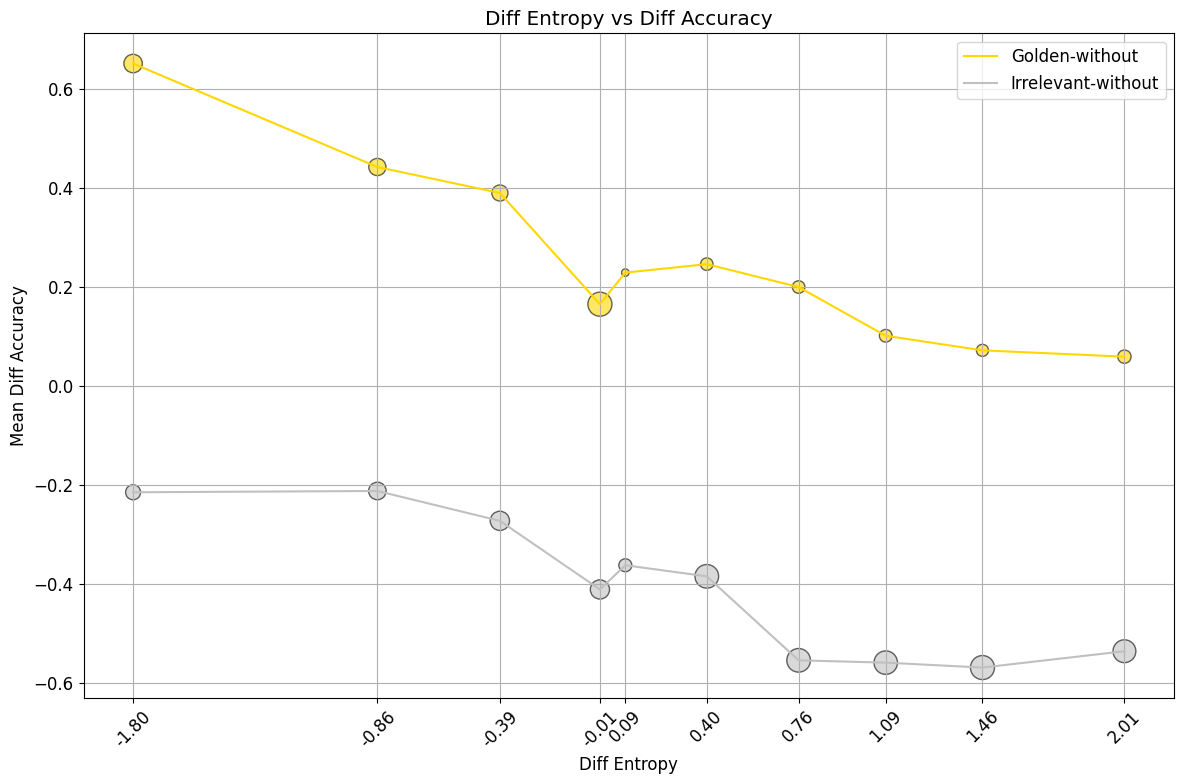

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 假设您的数据存储在名为data的变量中
# data = [...]  # 这里应该是您的2000条数据

# 示例数据结构（请用您的实际数据替换）
# data = [
#     {
#         "golden": {"entropy": 1.5, "accuracy_qwen": 1.0},
#         "irrelevant": {"entropy": 2.0, "accuracy_qwen": 0.8},
#         "without": {"entropy": 1.2, "accuracy_qwen": 0.9},
#     },
#     # ... 共2000条
# ]

def preprocess_data(data):
    records = []
    for entry in data:
        golden = entry.get('golden', {})
        irrelevant = entry.get('irrelevant', {})
        without = entry.get('without', {})
        
        # 计算 golden - without 的差异
        diff_entropy_golden_without = golden.get('entropy', np.nan) - without.get('entropy', np.nan)
        diff_accuracy_golden_without = golden.get('accuracy_qwen', np.nan) - without.get('accuracy_qwen', np.nan)
        
        # 计算 irrelevant - without 的差异
        diff_entropy_irrelevant_without = irrelevant.get('entropy', np.nan) - without.get('entropy', np.nan)
        diff_accuracy_irrelevant_without = irrelevant.get('accuracy_qwen', np.nan) - without.get('accuracy_qwen', np.nan)
        
        # 添加 golden - without 的记录
        records.append({
            'context': 'golden_without',
            'diff_entropy': diff_entropy_golden_without,
            'diff_accuracy': diff_accuracy_golden_without
        })
        
        # 添加 irrelevant - without 的记录
        records.append({
            'context': 'irrelevant_without',
            'diff_entropy': diff_entropy_irrelevant_without,
            'diff_accuracy': diff_accuracy_irrelevant_without
        })
    
    df = pd.DataFrame(records)
    # 去除缺失值
    df = df.dropna(subset=['diff_entropy', 'diff_accuracy'])
    return df

# 假设data已经被定义
# 例如，如果数据存储在JSON文件中，可以这样加载：
# import json
# with open('data.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)

df = preprocess_data(data)

# 分箱
num_bins = 10
df['diff_entropy_bin'] = pd.qcut(df['diff_entropy'], q=num_bins, duplicates='drop')

# 为每个箱计算中心值用于绘图
bin_centers = df.groupby('diff_entropy_bin')['diff_entropy'].mean()

# 计算每个上下文和每个箱的平均准确率差和样本数量
grouped = df.groupby(['context', 'diff_entropy_bin']).agg(
    average_diff_accuracy=('diff_accuracy', 'mean'),
    sample_count=('diff_accuracy', 'count')
).reset_index()

# 创建一个透视表，以便每个上下文都有独立的列
pivot_accuracy = grouped.pivot(index='diff_entropy_bin', columns='context', values='average_diff_accuracy')
pivot_count = grouped.pivot(index='diff_entropy_bin', columns='context', values='sample_count')

# 定义颜色映射
color_map = {
    'golden_without': 'gold',
    'irrelevant_without': 'silver'
}

# 绘图
plt.figure(figsize=(12, 8))

for context in ['golden_without', 'irrelevant_without']:
    if context in pivot_accuracy.columns:
        plt.plot(bin_centers, pivot_accuracy[context], label=context.replace('_', '-').capitalize(), color=color_map[context])
        # 使用样本数量调整点的大小，进行归一化处理
        counts = pivot_count[context]
        sizes = (counts / counts.max()) * 300  # 调整300为适当的最大大小
        plt.scatter(bin_centers, pivot_accuracy[context], color=color_map[context], s=sizes, alpha=0.6, edgecolors='k')

# 设置轴标签和标题
plt.xlabel('Diff Entropy')
plt.ylabel('Mean Diff Accuracy')
plt.title('Diff Entropy vs Diff Accuracy')
plt.legend()

# 优化x轴为箱的中心值
plt.xticks(bin_centers, [f'{bin_center:.2f}' for bin_center in bin_centers], rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

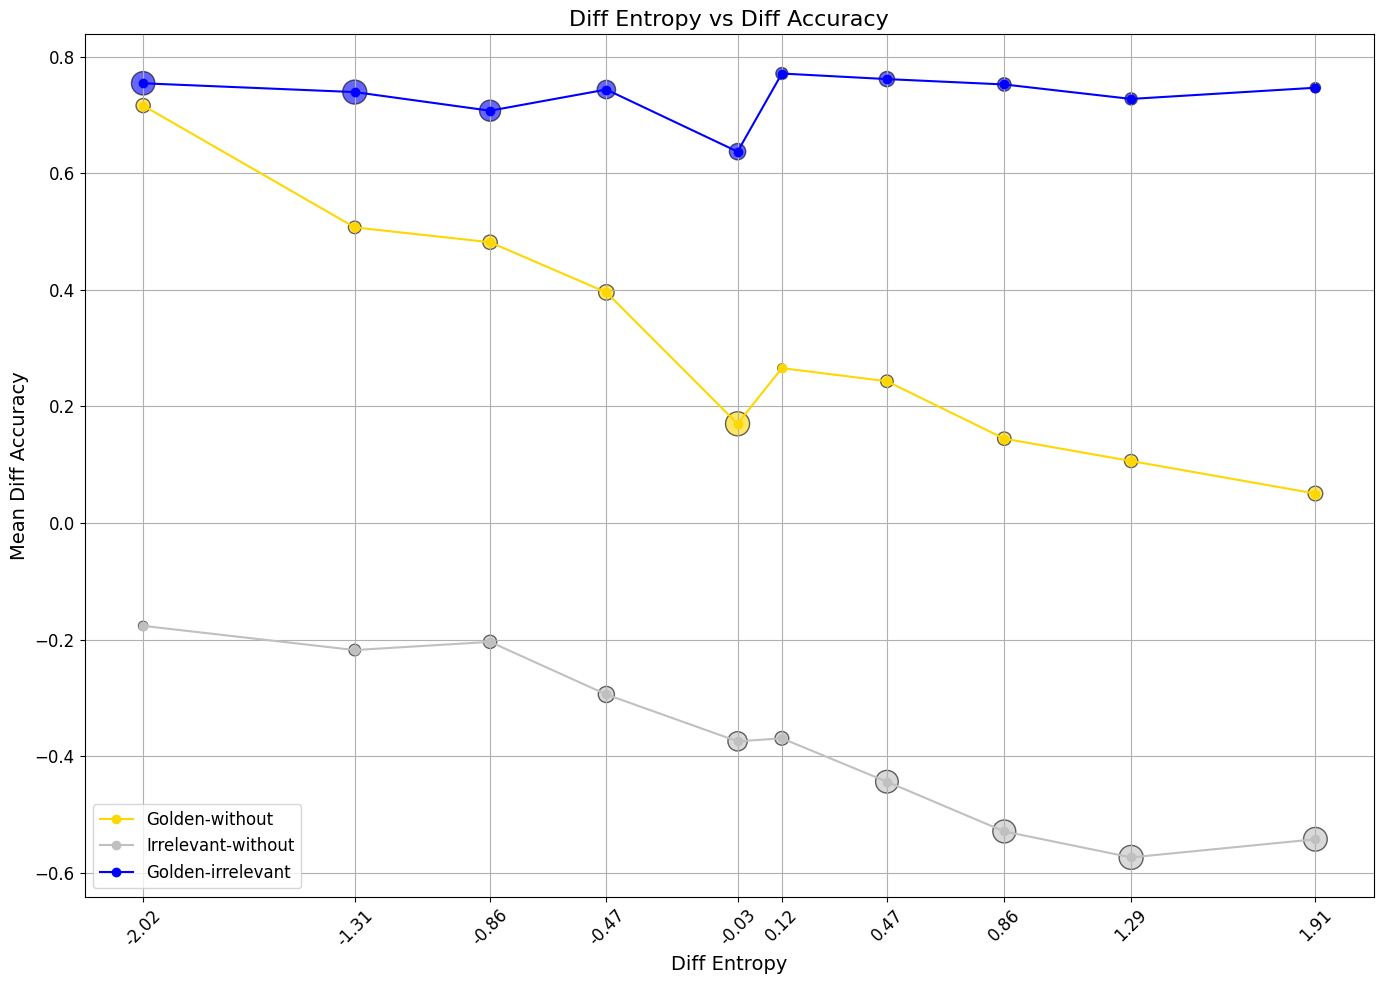

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

# 假设您的数据存储在名为data的变量中
# 如果数据存储在JSON文件中，可以这样加载：
# with open('data.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)

# 示例数据结构（请用您的实际数据替换）
# data = [
#     {
#         "golden": {"entropy": 1.5, "accuracy_qwen": 1.0},
#         "irrelevant": {"entropy": 2.0, "accuracy_qwen": 0.8},
#         "without": {"entropy": 1.2, "accuracy_qwen": 0.9},
#     },
#     # ... 共2000条
# ]

def preprocess_data(data):
    records = []
    for entry in data:
        golden = entry.get('golden', {})
        irrelevant = entry.get('irrelevant', {})
        without = entry.get('without', {})
        
        # 计算 golden - without 的差异
        diff_entropy_golden_without = golden.get('entropy', np.nan) - without.get('entropy', np.nan)
        diff_accuracy_golden_without = golden.get('accuracy_qwen', np.nan) - without.get('accuracy_qwen', np.nan)
        
        # 计算 irrelevant - without 的差异
        diff_entropy_irrelevant_without = irrelevant.get('entropy', np.nan) - without.get('entropy', np.nan)
        diff_accuracy_irrelevant_without = irrelevant.get('accuracy_qwen', np.nan) - without.get('accuracy_qwen', np.nan)
        
        # 计算 golden - irrelevant 的差异
        diff_entropy_golden_irrelevant = golden.get('entropy', np.nan) - irrelevant.get('entropy', np.nan)
        diff_accuracy_golden_irrelevant = golden.get('accuracy_qwen', np.nan) - irrelevant.get('accuracy_qwen', np.nan)
        
        # 添加 golden - without 的记录
        records.append({
            'context': 'golden_without',
            'diff_entropy': diff_entropy_golden_without,
            'diff_accuracy': diff_accuracy_golden_without
        })
        
        # 添加 irrelevant - without 的记录
        records.append({
            'context': 'irrelevant_without',
            'diff_entropy': diff_entropy_irrelevant_without,
            'diff_accuracy': diff_accuracy_irrelevant_without
        })
        
        # 添加 golden - irrelevant 的记录
        records.append({
            'context': 'golden_irrelevant',
            'diff_entropy': diff_entropy_golden_irrelevant,
            'diff_accuracy': diff_accuracy_golden_irrelevant
        })
    
    df = pd.DataFrame(records)
    # 去除缺失值
    df = df.dropna(subset=['diff_entropy', 'diff_accuracy'])
    return df

# 假设data已经被定义
# 例如，如果数据存储在JSON文件中，可以这样加载：
# with open('data.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)

# 这里假设data已经加载
# df = preprocess_data(data)

# 为了示例，这里创建一个假数据
# 请用您的实际数据替换下面的假数据
import random

def generate_fake_data(num_samples=2000):
    data = []
    for i in range(num_samples):
        entry = {
            "golden": {
                "entropy": random.uniform(0.5, 3.0),
                "accuracy_qwen": random.uniform(0.5, 1.0)
            },
            "irrelevant": {
                "entropy": random.uniform(0.5, 3.0),
                "accuracy_qwen": random.uniform(0.5, 1.0)
            },
            "without": {
                "entropy": random.uniform(0.5, 3.0),
                "accuracy_qwen": random.uniform(0.5, 1.0)
            }
        }
        data.append(entry)
    return data

# 生成假数据
# data = generate_fake_data(2000)
df = preprocess_data(data)

# 分箱
num_bins = 10
df['diff_entropy_bin'] = pd.qcut(df['diff_entropy'], q=num_bins, duplicates='drop')

# 为每个箱计算中心值用于绘图
bin_centers = df.groupby('diff_entropy_bin')['diff_entropy'].mean()

# 计算每个上下文和每个箱的平均准确率差和样本数量
grouped = df.groupby(['context', 'diff_entropy_bin']).agg(
    average_diff_accuracy=('diff_accuracy', 'mean'),
    sample_count=('diff_accuracy', 'count')
).reset_index()

# 创建一个透视表，以便每个上下文都有独立的列
pivot_accuracy = grouped.pivot(index='diff_entropy_bin', columns='context', values='average_diff_accuracy')
pivot_count = grouped.pivot(index='diff_entropy_bin', columns='context', values='sample_count')

# 定义颜色映射
color_map = {
    'golden_without': 'gold',
    'irrelevant_without': 'silver',
    'golden_irrelevant': 'blue'
}

# 绘图
plt.figure(figsize=(14, 10))

for context in ['golden_without', 'irrelevant_without', 'golden_irrelevant']:
    if context in pivot_accuracy.columns:
        plt.plot(bin_centers, pivot_accuracy[context], label=context.replace('_', '-').capitalize(), color=color_map[context], marker='o')
        # 使用样本数量调整点的大小，进行归一化处理
        counts = pivot_count[context]
        sizes = (counts / counts.max()) * 300  # 调整300为适当的最大大小
        plt.scatter(bin_centers, pivot_accuracy[context], color=color_map[context], s=sizes, alpha=0.6, edgecolors='k')

# 设置轴标签和标题
plt.xlabel('Diff Entropy', fontsize=14)
plt.ylabel('Mean Diff Accuracy', fontsize=14)
plt.title('Diff Entropy vs Diff Accuracy', fontsize=16)
plt.legend()
plt.grid(True)

# 优化x轴为箱的中心值
plt.xticks(bin_centers, [f'{bin_center:.2f}' for bin_center in bin_centers], rotation=45)

plt.tight_layout()
plt.show()